# V1.0 EMCCD仿真模块

Cpic仿真程序中的emccd仿真模块对系统中的EMCCD进行仿真，包括暗电流、非均匀性、非线性、增益、电子倍增等效应。

EMCCD类为emccd仿真模块的主类，包含了EMCCD的各种参数，以及对应的仿真函数。

该版本的EMCCD仿真模块只包括最基础的理论噪声，如果需要更复杂的仿真，请使用V2.0版本。






In [ ]:
from CpicImgSim import EMCCD
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

def psf_imshow(psf, vmin=1e-8, vmax=0.1):
    focal_img = psf.copy()
    focal_img = np.maximum(focal_img, vmin)
    focal_img = np.minimum(focal_img, focal_img.max()*vmax)
    image_log = np.log10(focal_img)
    plt.imshow(image_log, origin='lower', cmap='gray')

EMCCD类在初始化时，根据cpism_refdata/emccd/emccd_config.yaml中的内容，读取暗场、平场、CIC场的fits文件，并设置为类的属性。
下面几幅图为默认的参考图像。

Text(0.5, 1.0, 'CIC')

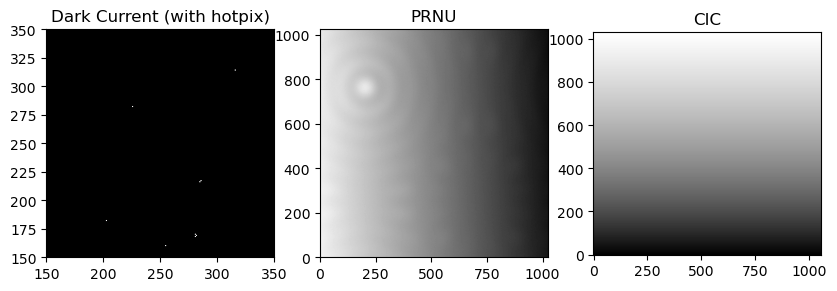

In [ ]:
emccd = EMCCD() 

f, ax = plt.subplots(3, 1, figsize=(10, 4))
plt.subplot(1, 3, 1)
psf_imshow(emccd.dark, vmin=0, vmax=1)
plt.xlim([150, 350])
plt.ylim([150, 350])
plt.title('Dark Current (with hotpix)')
plt.subplot(1, 3, 2)
psf_imshow(emccd.flat, vmin=0, vmax=1)
plt.title('PRNU')
plt.subplot(1, 3, 3)
psf_imshow(emccd.cic, vmin=0, vmax=1)
plt.title('CIC')

使用EMCCD类的readout方法，可以获取焦面图像。该方法的输入为焦面图像、电子倍增、曝光时间。为图像增加暗噪声、CIC噪声、不均匀性、非线性、电子倍增效应、CIC效应等、AD量化等效应，输出以ADU为单位的图像。

各效应可以通过emccd_config.yaml中的参数进行开关和配置

下图为读出噪声的分布。

Text(0, 0.5, 'count')

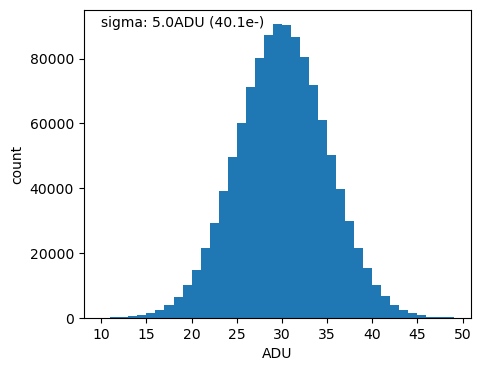

In [4]:
focal_img = np.zeros(emccd.flat_shape)
img = emccd.readout(focal_img, emgain=1, expt=0)
plt.figure(figsize=(5, 4))
plt.hist(img.flatten(), bins=range(10, 50))
std = img.flatten().std()
plt.text(10, 90000, f'sigma: {std :.1f}ADU ({std * emccd.ph_per_adu :.1f}e-)')
plt.xlabel('ADU')
plt.ylabel('count')

下图为存在电子倍增情况下，读出噪声和CIC噪声的分布。

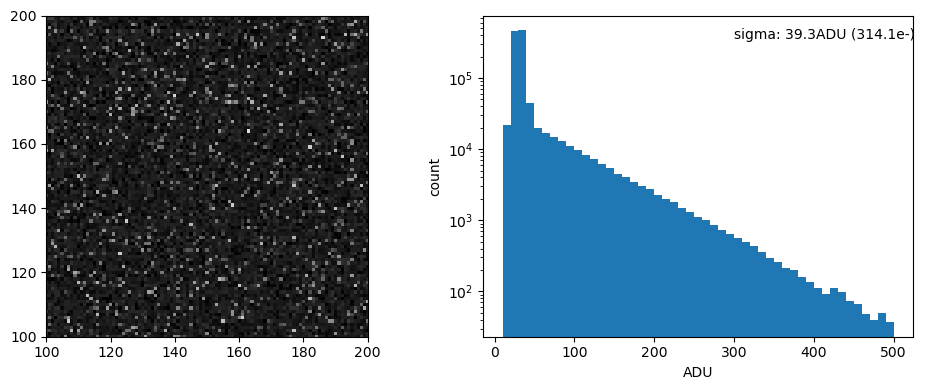

In [5]:
focal_img = np.zeros(emccd.flat_shape)
img = emccd.readout(focal_img, emgain=500, expt=0)

std = img.flatten().std()
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
psf_imshow(img, vmin=20, vmax=1)
plt.xlim([100, 200])
plt.ylim([100, 200])

plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=np.linspace(10, 500, 50), log=True)
plt.text(300, 350000, f'sigma: {std :.1f}ADU ({std * emccd.ph_per_adu :.1f}e-)')
plt.xlabel('ADU')
plt.ylabel('count')

plt.tight_layout()

In [ ]:
下图为暗电流的分布.

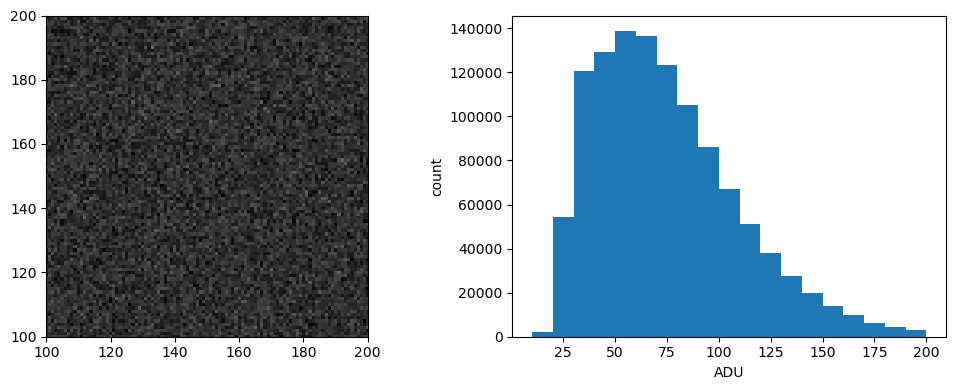

In [6]:
focal_img = np.zeros(emccd.flat_shape)
img = emccd.readout(focal_img, emgain=100, expt=36000)

std = img.flatten().std()
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
psf_imshow(img, vmin=20, vmax=1)
plt.xlim([100, 200])
plt.ylim([100, 200])

plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=np.linspace(10, 200, 20), log=False)
# plt.text(100, 120000, f'sigma: {std :.1f}ADU ({std * emccd.ph_per_adu :.1f}e-)')
plt.xlabel('ADU')
plt.ylabel('count')

plt.tight_layout()

下面的例子中，我们读取一幅之前生成的焦面图像，使用emccd类可以获得相机读出后的图像。

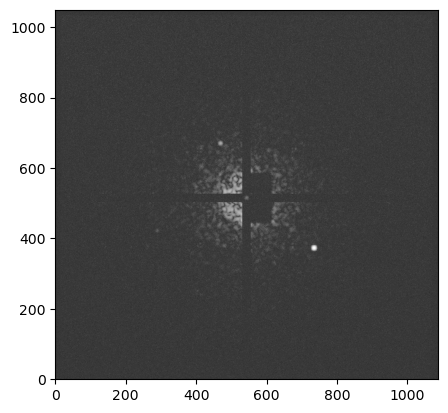

In [7]:
# 生成科学观测图像
area = 100 ** 2 * 3.14
focal_img = fits.getdata('image_files/focal_img.fits') * area

camera_output = emccd.readout(focal_img, 100, 20)

psf_imshow(camera_output, vmin=0, vmax=1)


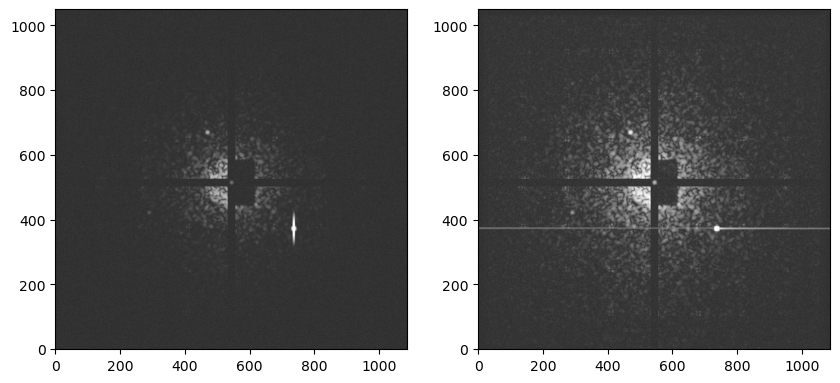

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
camera_output = emccd.readout(focal_img, 1, 2000)
psf_imshow(camera_output, vmin=0, vmax=1)

plt.subplot(1,2,2)
camera_output = emccd.readout(focal_img, 100, 200)
psf_imshow(camera_output, vmin=0, vmax=1)

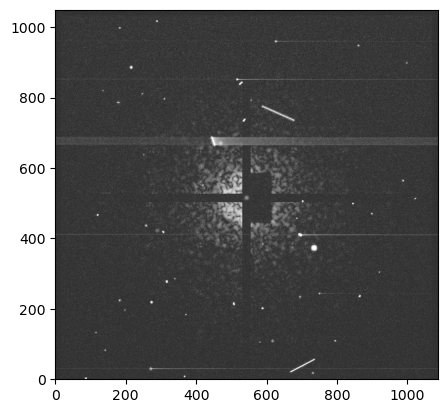

In [10]:
cr_frame = fits.getdata('cr_frame_30s.fit')
camera_output = emccd.readout(focal_img, 200, 30, image_cosmic_ray=cr_frame)
psf_imshow(camera_output, vmin=0, vmax=1)